In [35]:
import numpy as np
import pandas as pd 
import os
from jarviscloud import jarviscloud
from torch import nn
import torch
from tqdm import tqdm
import albumentations as A
import cv2
import timm
import sys
import matplotlib.pyplot as plt
from torchvision import transforms
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML, display

import torchvision.transforms.functional as F
sys.path.append("../python/")

from hyperparams import Hyperparams
import model_classes as mc
from stratified_kfold_loaders import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mc.VanillaVariationalAutoEncoder(1024,20)
model.eval()
state_dict = torch.load('../running_models/fold_1/me_0.054_ep_20_en_efficientnet_b2_lr_0.0005_si_28.pt', map_location = device)
model.to(device)
model.load_state_dict(state_dict, strict = True)


normalise_transform = transforms.Compose([
    transforms.Normalize(mean=(159.5562), std=(48.8289))
    ])

In [3]:
all_images = np.load('../data/sign_language_images/images.npy')

In [4]:
images = torch.tensor(F.adjust_sharpness(torch.tensor(all_images),1).squeeze(0).numpy()).to(device).float()
images = normalise_transform(images)

In [5]:
with torch.no_grad():
    outputs,_ ,_ = model(images)

# outputs = F.adjust_sharpness(outputs,0.2)

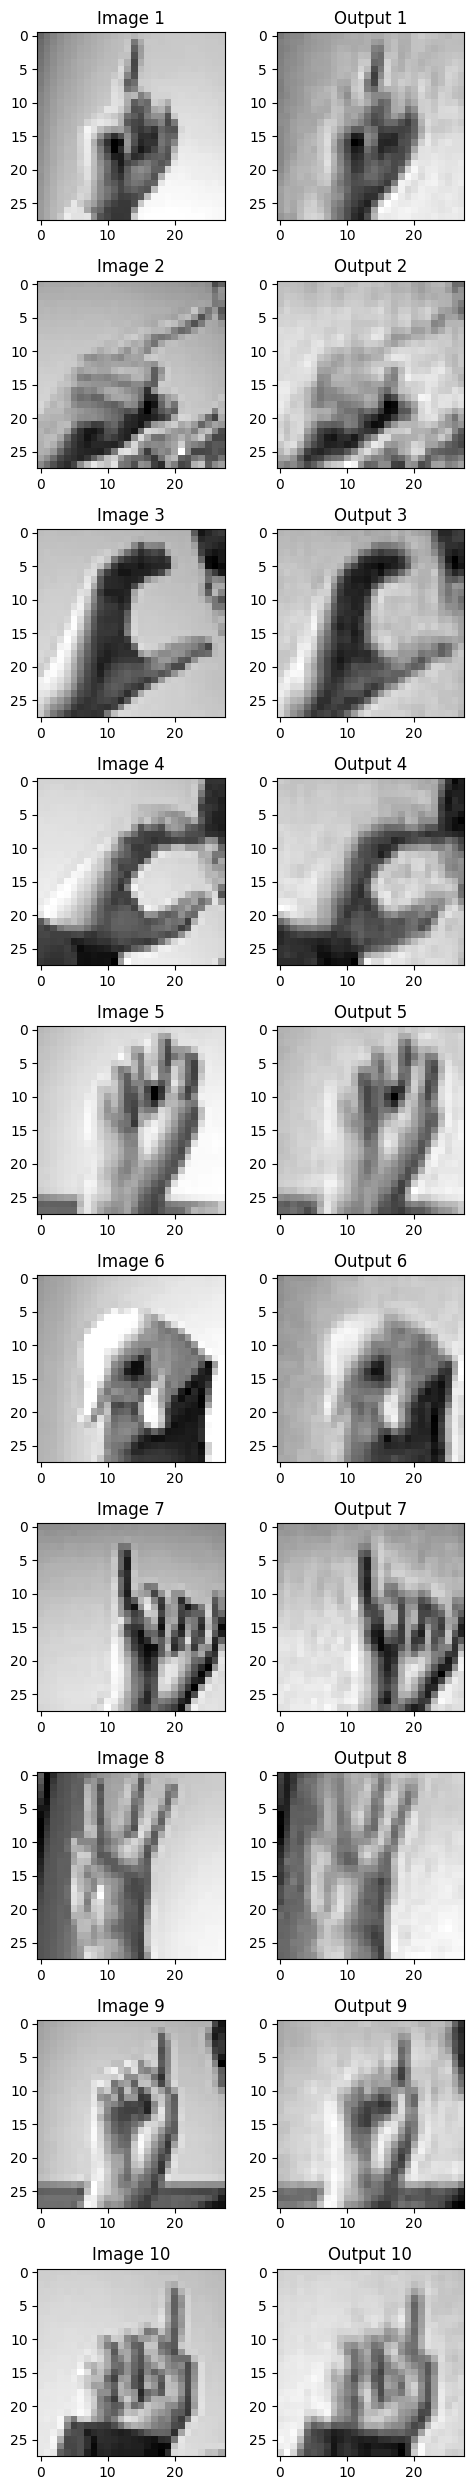

In [6]:
plt.figure(figsize=(5, 25))
start = 0
for i in range(start,start+10):
    plt.subplot(10, 2, 2*(i-start)+1)
    plt.imshow((images[i] ).cpu().squeeze(0), cmap='gray')
    plt.title(f'Image {i+1}')
    
    plt.subplot(10, 2, 2*(i-start)+2)
    plt.imshow(outputs[i].cpu().squeeze(0), cmap='gray')
    plt.title(f'Output {i+1}')

plt.tight_layout()
plt.show()

In [7]:
with torch.no_grad():
    latent_space = model.encode(images)

In [8]:
latent_space.max(0), latent_space.min(0)

(torch.return_types.max(
 values=tensor([3.7987, 4.5796, 3.2570, 3.9787, 3.8988, 4.0805, 4.1707, 4.1545, 4.0594,
         4.1039, 3.2954, 3.4251, 3.3252, 4.2325, 4.6698, 4.5785, 4.2409, 3.3917,
         4.1203, 3.9948], device='cuda:0'),
 indices=tensor([11804,  2926,  7250, 14227,  9220, 26105,  3983, 26383, 27005,  1132,
           872,   274, 15984, 26568, 14901, 22221, 12869, 21248,  4999, 18833],
        device='cuda:0')),
 torch.return_types.min(
 values=tensor([-4.1769, -3.7542, -3.5839, -4.2019, -3.5324, -4.3008, -3.7923, -4.3252,
         -3.5322, -3.7848, -4.1865, -3.5437, -4.2960, -4.2541, -4.2415, -3.3420,
         -3.6366, -3.2624, -3.2006, -3.7207], device='cuda:0'),
 indices=tensor([27506,  1885, 34585,  4411, 17237, 14705, 22173, 23674, 28227, 17274,
         22590,  6463, 12619, 17630, 33144, 22490, 26035, 12122, 34193,  4430],
        device='cuda:0')))

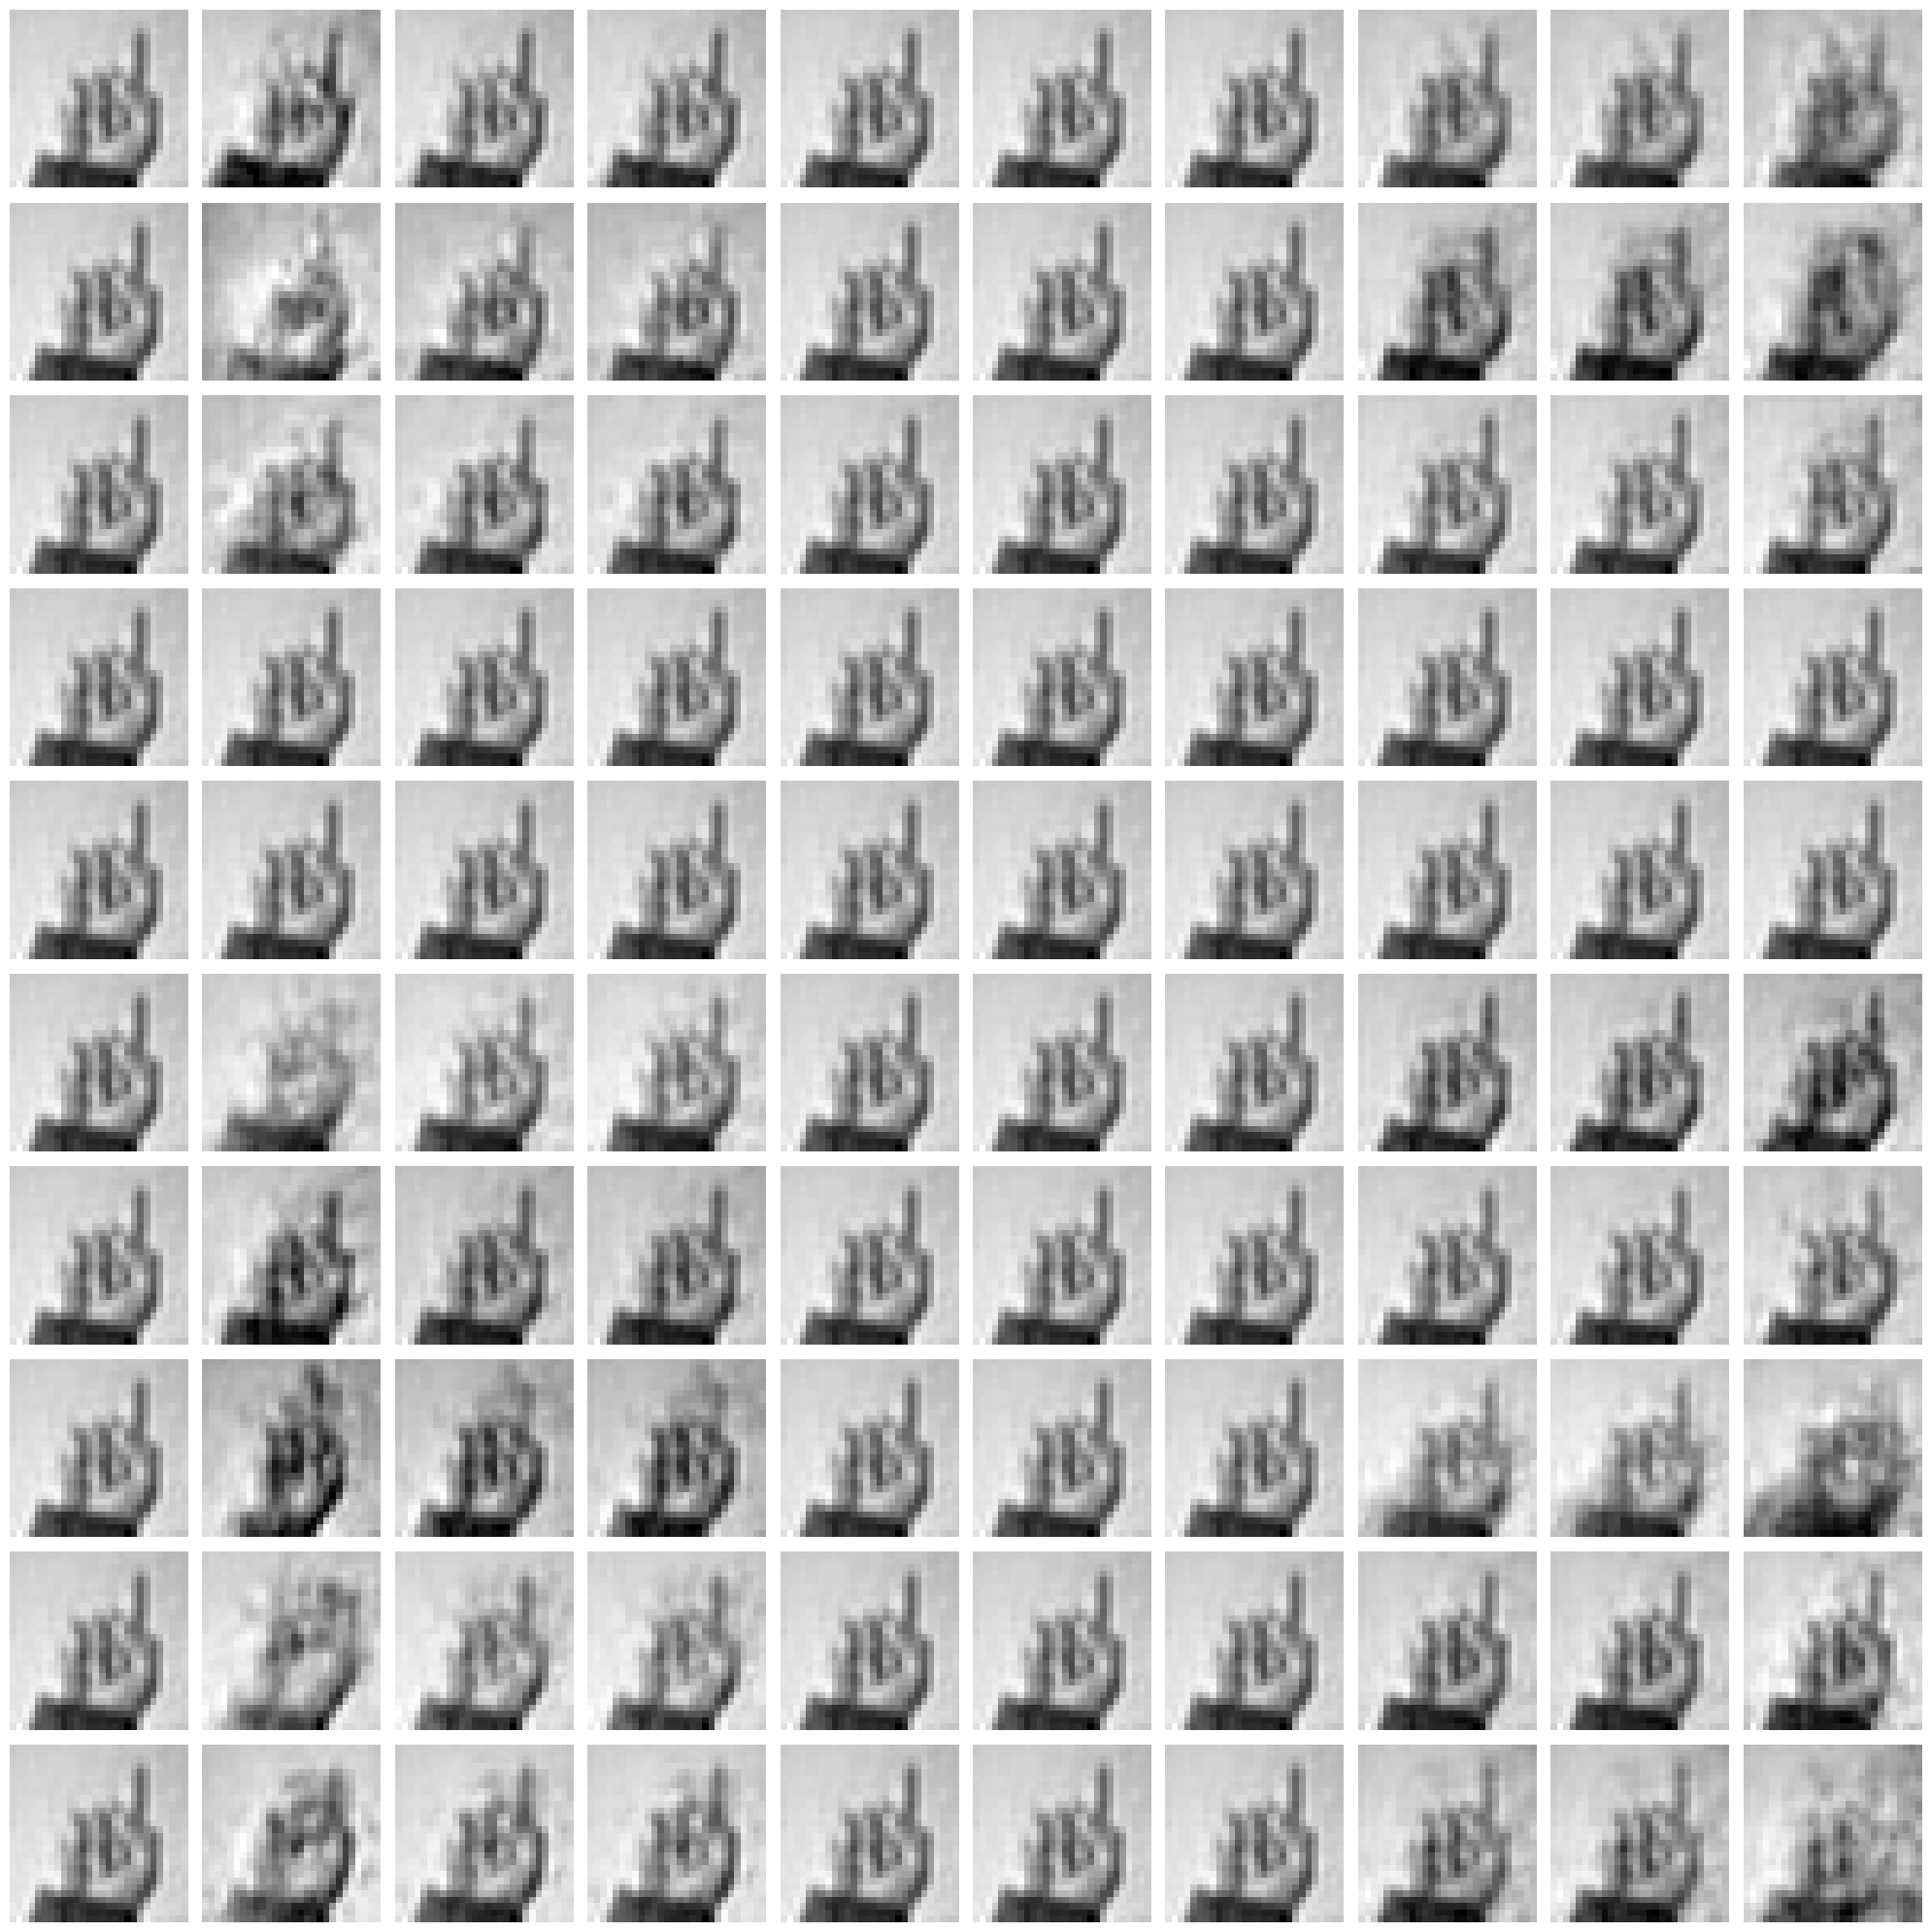

In [68]:
img_index = 10

# Assuming you already have defined the following:
# latent_space, device, model

# Create a figure
plt.figure(figsize=(20, 20))  # Adjust the size to fit 10x10 images

start = -2
stop = 2
values  = list(np.linspace(start, stop, 9))
values = [0] + values

# Loop over each dimension
start_dim = 10
for dim in range(10,start_dim + 10):
    
    # Loop over each value to be added
    for i, value in enumerate(values):
        value = int(value)
        
        # Create a tensor with only the current dimension modified
        change_tensor = torch.zeros(20).to(device)
        change_tensor[dim] = value
        
        good_embedding = latent_space[img_index-1] + change_tensor
        
        with torch.no_grad():
            decoded_image = model.decode(good_embedding.unsqueeze(0)).squeeze((0, 1)).cpu().numpy()
            
            # Plot the image in a subplot
            plt.subplot(10, 10, (dim- start_dim)*10 + i + 1)
            plt.imshow(decoded_image, cmap='gray')
            plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()


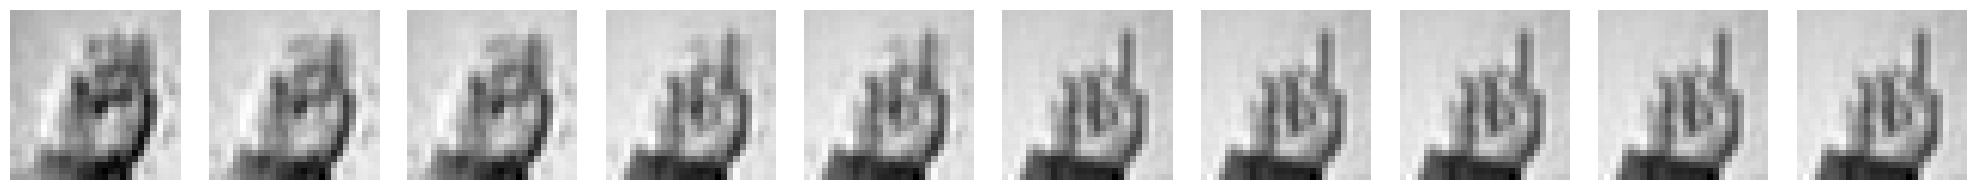

In [22]:
plt.figure(figsize=(20, 2))  # Adjust the size to fit 10 images in a row

start = -3
stop = 0.9
values  = np.linspace(start,stop,10)
dim = 19
for i,value in enumerate(values):
    
    
    value = int(value)

    change_tensor = torch.zeros(20).to(device)
    change_tensor[dim] = value


    good_embedding = latent_space[9] + change_tensor
    
    with torch.no_grad():
        decoded_image = model.decode(good_embedding.unsqueeze(0)).squeeze((0, 1)).cpu().numpy()
        
        # Plot the image in a subplot
        plt.subplot(1, 10, i+1)
        plt.imshow(decoded_image, cmap='gray')
        plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [61]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Assuming necessary imports for torch and the model are already done

def generate_image(value, dim=19):
    value = int(value)
    change_tensor = torch.zeros(20).to(device)
    change_tensor[dim] = value
    good_embedding = latent_space[9] + change_tensor
    with torch.no_grad():
        decoded_image = model.decode(good_embedding.unsqueeze(0)).squeeze((0, 1)).cpu().numpy()
    return decoded_image

start = -5
stop = 0.9
values = np.concatenate((np.linspace(start, stop, 100),np.linspace(stop, stop, 100)))
frames = [generate_image(value) for value in values]

def update(frame_idx):
    im.set_array(frames[frame_idx])
    return [im]

ani = FuncAnimation(fig, update, frames=len(frames), interval=10, blit=True)
HTML(ani.to_jshtml())

In [66]:
gif_path = "../plots/animation.gif"
ani.save(gif_path, writer='imagemagick', fps=40)

MovieWriter imagemagick unavailable; using Pillow instead.
